In [1]:
# sport_classification_no_transfer.ipynb

# ====================================
# 1. IMPORTY I USTAWIENIA
# ====================================
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

print(tf.__version__)  # Upewnij się, że TensorFlow działa poprawnie

# Ustawienia
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 6  # 6 sportów
EPOCHS = 15

# ====================================
# 2. GENERATORY DANYCH
# ====================================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory='data/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    directory='data/valid',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    directory='data/test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# ====================================
# 3. ZBUDOWANIE SIECI VGG16
# ====================================
# Ładowanie modelu VGG16 bez górnych warstw
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Dodanie nowych warstw, które będą dostosowane do Twojego problemu
x = layers.Flatten()(base_model.output)
x = layers.Dense(128, activation='relu')(x)
output_layer = layers.Dense(NUM_CLASSES, activation='softmax')(x)

# Definicja całego modelu
model = Model(inputs=base_model.input, outputs=output_layer)

# Zamrożenie wag wstępnie nauczonych warstw
for layer in base_model.layers:
    layer.trainable = False

model.summary()

# ====================================
# 4. KOMPILACJA
# ====================================
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# ====================================
# 5. TRENING
# ====================================
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=valid_generator
)

# ====================================
# 6. EWALUACJA
# ====================================
val_loss, val_accuracy = model.evaluate(valid_generator)
print(f"Validation loss: {val_loss:.4f}, Validation accuracy: {val_accuracy:.4f}")

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")

# ====================================
# 7. ZAPISANIE MODELU
# ====================================
model.save("sport_classifier_no_transfer.keras")


2.18.0
Found 901 images belonging to 6 classes.
Found 30 images belonging to 6 classes.
Found 30 images belonging to 6 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,926,854 (68.39 MB)

 Trainable params: 3,212,166 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

C:\Users\barte\PycharmProjects\sports-ai\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3140 - loss: 3.4914

C:\Users\barte\PycharmProjects\sports-ai\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 173s 6s/step - accuracy: 0.3188 - loss: 3.4473 - val_accuracy: 0.9000 - val_loss: 0.5874
Epoch 2/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 163s 6s/step - accuracy: 0.7561 - loss: 0.6571 - val_accuracy: 1.0000 - val_loss: 0.2287
Epoch 3/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 163s 6s/step - accuracy: 0.8851 - loss: 0.3770 - val_accuracy: 1.0000 - val_loss: 0.1701
Epoch 4/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 128s 4s/step - accuracy: 0.9099 - loss: 0.2613 - val_accuracy: 0.9000 - val_loss: 0.2191
Epoch 5/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 111s 4s/step - accuracy: 0.9258 - loss: 0.2304 - val_accuracy: 1.0000 - val_loss: 0.0994
Epoch 6/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 110s 4s/step - accuracy: 0.9358 - loss: 0.2050 - val_accuracy: 0.9667 - val_loss: 0.0817
Epoch 7/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 118s 4s/step - accuracy: 0.9465 - loss: 0.1798 - val_accuracy: 0.9667 - val_loss: 0.0921
Epoch 8/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 124s 4s/step - accuracy: 0.9466 - loss: 0.1641 - val_accuracy: 0.9667 - val_loss: 0.

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Ścieżka do zapisanego modelu
MODEL_PATH = "sport_classifier_no_transfer.keras"

# Nazwy klas w takiej kolejności, w jakiej były trenowane w generatorze
class_names = [
    "baseball",
    "cricket",
    "mushing",
    "nascar racing",
    "rock climbing",
    "swimming"
]

# Wczytanie wytrenowanego modelu
model = load_model(MODEL_PATH)

def predict_sport(image_path, model, class_names):
    """
    Funkcja wczytuje pojedynczy obraz, przetwarza go
    i zwraca przewidywaną etykietę (oraz pewność).
    """
    # 1. Wczytanie obrazu i przeskalowanie do rozmiaru 224x224
    img = load_img(image_path, target_size=(224, 224))

    # 2. Konwersja do tablicy NumPy i normalizacja do zakresu [0, 1]
    img_array = img_to_array(img) / 255.0

    # 3. Dodanie wymiaru batch (1, 224, 224, 3), aby sieć mogła przetwarzać dane
    img_array = np.expand_dims(img_array, axis=0)

    # 4. Przewidywanie
    predictions = model.predict(img_array)  # shape: (1, NUM_CLASSES)

    # 5. Indeks klasy z najwyższym prawdopodobieństwem
    predicted_index = np.argmax(predictions[0])
    predicted_label = class_names[predicted_index]

    # Opcjonalnie pewność predykcji (confidence)
    confidence = predictions[0][predicted_index]

    return predicted_label, confidence

# Ścieżka do przykładowego zdjęcia
# (zmień na własną ścieżkę, np. 'test_images/my_image.jpg')
test_image_path = "image9.jpg"

# Klasyfikacja
label, conf = predict_sport(test_image_path, model, class_names)

print(f"Przewidywany sport: {label}")
print(f"Pewność modelu: {conf * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
Przewidywany sport: cricket
Pewność modelu: 77.51%


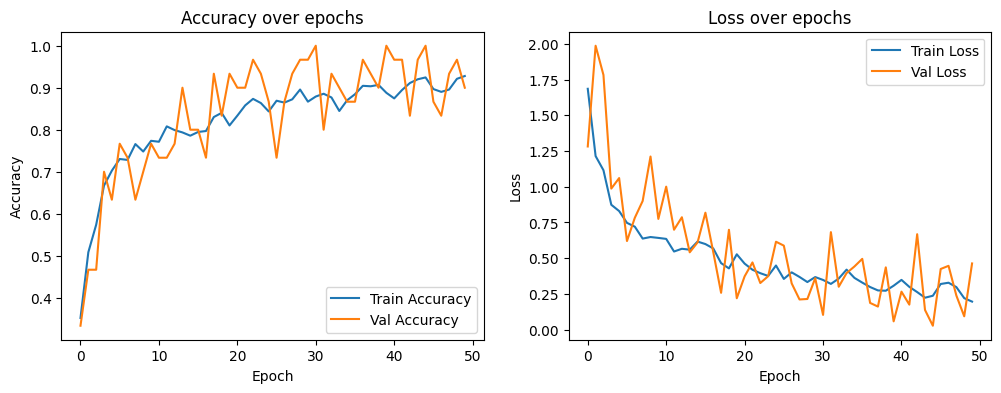

In [4]:
# ====================================
# 8. ZAPISANIE I WIZUALIZACJA HISTORII TRENOWANIA
# ====================================
import matplotlib.pyplot as plt

# 1. Wyciągnięcie historii trenowania
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# 2. Przygotowanie zakresu epok do wyświetlenia na osi X
epochs_range = range(EPOCHS)

# 3. Wykresy Accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 4. Wykresy Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 5. Zapisanie wykresu do pliku (opcjonalne)
plt.savefig('training_history.png', dpi=100)

plt.show()